In [532]:
#Change notebook styling
from IPython.display import HTML
HTML("""
<link href='https://fonts.googleapis.com/css?family=Lato' rel='stylesheet' type='text/css'>
<style>
div.text_cell_render {
    font-family: 'Lato' sans-serif;
    line-height: 130%;
    font-size: 115%;
    width:700px;
}
div.output_area {
    font-family: 'Lato' sans-serif;
    line-height: 130%;
    font-size: 115%;
    margin-left: 100px;
    width:750px;
}
.dataframe * {
    border: 1px solid lightgray !important;
}
div.output_prompt {display: none;}
div.output_area pre {display: none;}

</style>
""")

# A Look at Github Commit Messages

I have always wondered - am I doing commit messages right?  With all commit messages on Github being accessible, we can see what conventions are being followed by Github users and which are being ignored.

Github generously [posts event data](https://www.githubarchive.org/) back to 2011 on Google BigQuery, making it dead simple to analyze this massive dataset. I took a look at commit data for 2015 and some summary statistics from 2014 through January 2016. The monthly tables for 2015 contain 514 GB of data and 211 M rows - credit to BigQuery - all queries for this project took at most a little over a minute.

In the interest of presentation, all code is hidden.  You can toggle it with the button below.

In [368]:
#Add button to toggle code - http://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle code"></form>''')

In [237]:
%matplotlib inline

from apiclient.discovery import build
from apiclient.errors import HttpError
from oauth2client.client import GoogleCredentials
import itertools
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display
from IPython.display import Image
from bokeh.plotting import *
import matplotlib.ticker as ticker

matplotlib.style.use('ggplot')

#Set GOOGLE_APPLICATION_CREDENTIALS environment variable
credentials = GoogleCredentials.get_application_default()
bigquery_service = build('bigquery', 'v2', credentials=credentials)

with open('config.json') as json_config:
    config = json.load(json_config)
    
project_id = config['project_id']

In [528]:
#Patch in comma thousands seperator for int in dataframe
class _IntArrayFormatter(pd.core.format.GenericArrayFormatter):

    def _format_strings(self):
        formatter = self.formatter or (lambda x: ' {:,}'.format(x))
        fmt_values = [formatter(x) for x in self.values]
        return fmt_values

pd.core.format.IntArrayFormatter = _IntArrayFormatter

In [241]:
summary_query_request = bigquery_service.jobs()

summary_query = '''select
            type, %s as payload_type, count(type)
            from githubarchive:month.%s
            group by 1,2 limit 100;'''

years = ['2014','2015','2016']
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
dates = [y+m for y,m in list(itertools.product(years,months))]
summary_query_results = []
for date in dates:
    try:
        #data format changes in January 2015 - use different column names before and after
        column_name = 'payload_ref_type' if int(date) < 201500 else "JSON_EXTRACT(payload, '$.ref_type')"
        summary_query_data = {
                    'query': (summary_query %(column_name, date))
        }
        summary_query_response = summary_query_request.query(
                    projectId=project_id,
                    body=summary_query_data).execute()
        
        for row in summary_query_response['rows']:
            event_type = row['f'][0]['v']
            payload_type = row['f'][1]['v']
            value = int(row['f'][2]['v'])
            summary_query_results.append({'date':date, 'event_type':event_type, 'payload_type':payload_type, 'value':value})
    except: pass

In [325]:
event_df=pd.DataFrame(summary_query_results)
event_df['detailed_type'] = event_df.apply(
                                lambda x: x['event_type'] + ': ' + x['payload_type'].strip("\"") 
                                    if pd.notnull(x['payload_type']) 
                                    else x['event_type'], axis=1)

Before we dig into commits, lets check out some summary statistics.  The number of repositories created in January 2016 has more than doubled since January 2014 with 951k new repositories from 415k.  The number of tags have also roughly doubled (244k from 109k) while branches have almost quadrupled (1764k from 468k). People may need to clean up some branches.

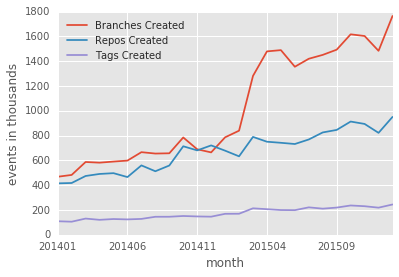

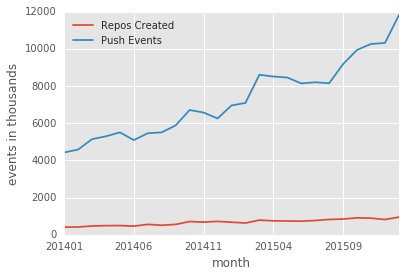

In [401]:
included_columns = ['CreateEvent: repository', 'CreateEvent: tag', 'CreateEvent: branch']
create_events_df=event_df[event_df['detailed_type'].isin(included_columns)].pivot(index='date', columns='detailed_type', values='value')
ax1 = create_events_df.plot()
included_columns = ['CreateEvent: repository', 'PushEvent']
create_events_df=event_df[event_df['detailed_type'].isin(included_columns)].pivot(index='date', columns='detailed_type', values='value')
ax2 = create_events_df.plot()

#Chart Formatting
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax1.yaxis.set_major_formatter(ticks_y)
ax1.set_ylabel('events in thousands')
ax1.set_xlabel('month')
ax2.yaxis.set_major_formatter(ticks_y)
ax2.set_ylabel('events in thousands')
ax2.set_xlabel('month')
ax1.legend(loc='upper left', labels=['Branches Created', 'Repos Created','Tags Created'])
ax2.legend(loc='upper left', labels=['Repos Created', 'Push Events'])

Lets take a look at the top commit messages:

In [512]:
#Chart: First Words
commit_query_request = bigquery_service.jobs()

#Get Top 5000 commit messages (lower case) with message counts and unique repo counts for 2015
query = '''
SELECT
LOWER(message), 
COUNT(LOWER(message)) as message_count,
EXACT_COUNT_DISTINCT(repo_id) as unique_repo_count
FROM (
  SELECT
  id,
  repo_id,
  REGEXP_EXTRACT(SPLIT(JSON_EXTRACT(payload, '$.commits'),"},{"),r'"message":"(.+)",') AS message 
  FROM TABLE_QUERY([githubarchive:month],'REGEXP_MATCH(table_id, r"^2015.+")')
  WHERE type = 'PushEvent'
  AND JSON_EXTRACT(payload, '$.commits') != '[]'
)
group by 1 order by 2 desc limit 5000
'''

commit_query_response = commit_query_request.query(
            projectId=project_id,
            body={'query':query,'timeoutMs':5000000}).execute()
commit_query_results = []
for row in commit_query_response['rows']:
    commit_message = row['f'][0]['v']
    message_count = int(row['f'][1]['v'])
    unique_repo_count = int(row['f'][2]['v'])
    commit_query_results.append({
            'commit_message':commit_message, 
            'message_count':message_count, 
            'unique_repo_count':unique_repo_count})

In [544]:
commit_df = pd.DataFrame(commit_query_results)

In [545]:
commit_df['rank']= commit_df['message_count'].rank(ascending=False)
commit_df=commit_df.set_index('rank').reset_index()
commit_df.columns = ['Rank', 'Commit Message', 'Count', 'Unique Repos']
#display data frame without index
display(HTML(commit_df.head(25).to_html(index=False)))

Rank,Commit Message,Count,Unique Repos
1,update readme.md,"2,463,375","857,734"
2,update,"1,444,117","159,522"
3,update index.html,"490,255","90,740"
4,create readme.md,"465,997","431,775"
5,'privacy sync',"432,552",44
6,initial commit,"431,046","295,502"
7,test,"421,555","145,133"
8,auto,"404,816",590
9,commit,"273,705","42,551"
10,first commit,"257,150","180,263"


The top 25 commit messages for 2015 are shown above (converted to lower case).  As expected, alot of these have to do with readmes. There are also some messages that occur frequently in a small number of repos suggesting automated commits - *'privacy sync'* and *test - clear repository branch* for example. Initial commit beats out first commit, and some popular messages for those who can't be bothered are shown - *a*, *.*, *no message* and simply *commit*.

In [226]:
commit_stat_request = bigquery_service.jobs()

query = '''SELECT
REGEXP_MATCH(LOWER(message), r'^\S+(ed)\S* .+') as past_tense,
REGEXP_MATCH(message, r'^([A-Z]).+') as capitalized,
message CONTAINS '\\\\n' AS multiline_message,
count(message) AS count
FROM (
  SELECT
  id,
  repo_id,
  REGEXP_EXTRACT(SPLIT(JSON_EXTRACT(payload, '$.commits'),"},{"),r'"message":"(.+)",') AS message 
  FROM [github_sample_data.month_sample]
  --FROM TABLE_QUERY([githubarchive:month],'REGEXP_MATCH(table_id, r"^2015.+")')
  WHERE type = 'PushEvent'
  AND JSON_EXTRACT(payload, '$.commits') != '[]'
)
group by 1,2,3
'''
commit_stat_response = commit_stat_request.query(
            projectId=project_id,
            body={'query':query,'timeoutMs':5000000}).execute()
commit_stat_results = []
for row in commit_stat_response['rows']:
    past_tense = row['f'][0]['v']
    capitalized = row['f'][1]['v']
    multiline_message = row['f'][2]['v']
    count = int(row['f'][3]['v'])
    commit_stat_results.append({
            'past_tense':past_tense, 
            'capitalized':capitalized,
            'multiline_message':multiline_message,
            'count':count})

There are [many](http://chris.beams.io/posts/git-commit/) [github](http://tbaggery.com/2008/04/19/a-note-about-git-commit-messages.html) [commit message](https://git-scm.com/book/ch5-2.html) [guides](https://github.com/erlang/otp/wiki/Writing-good-commit-messages) out there.  I borrowed a few rules from [Chris Beam's](http://chris.beams.io/posts/git-commit/) guide:
- Use the imperative tense (e.g. use add vs added)
- Capitalize the first letter
- Separate subject from body with a blank line
- Limit the subject line to 50 characters

Lets see what people actually do:

In [519]:
commit_stat_df = pd.DataFrame(commit_stat_results)
output_notebook(hide_banner=True)

def create_percentage_plot(_df, metric_name, title, reverse=False):
    df = _df[[metric_name, 'count']].groupby(metric_name).sum()
    df['percentage']=df['count']/df['count'].sum()
    df=df.reset_index()
    percentage_true = df[df[metric_name]=='true']['percentage'].values[0]
    if reverse:
        percentage_true = 1-percentage_true
    item_count = df[['count']].sum().values[0]
    title = title + ' (n='+str(item_count)+')'
    p = figure(width=300, height=250, toolbar_location=None, 
               tools=[], title=title, title_text_font_size='12pt', title_text_font='Lato')
    p.quad(top=[percentage_true], bottom=[0], left=[0], right=[1], color="#0B486B") #True Box
    p.quad(top=[1], bottom=[percentage_true], left=[0], right=[1], color="#CFF09E") #False Box
    p.text(.5, .02, text=["{0:.2f}".format(percentage_true*100) + '% - Yes'], text_font='Lato', text_color="white", text_align="center", text_baseline='bottom', text_font_size="12pt")
    p.text(.5, .98, text=["{0:.2f}".format(100-percentage_true*100) + '% - No'], text_font='Lato', text_color="black", text_align="center", text_baseline='top', text_font_size="12pt")
    p.axis.visible = None
    p.grid.grid_line_color = None
    return p

p = gridplot([
        [
            create_percentage_plot(commit_stat_df, 'capitalized', 'First letter is capitalized'),
            create_percentage_plot(commit_stat_df, 'multiline_message', 'Contains multiple lines')

        ],
        [
            create_percentage_plot(commit_stat_df, 'past_tense', 'Uses the imperative tense', reverse=True)           
        ]
    ])
show(p)

Of course any data project has outliers - this one is no different.  

There is [this project](https://github.com/simonAllier/benoit-exp-result) which manages over 350,000 commits at the time of writing.

Also, 'Tell the children the truth.' struck my eye as an odd commit choice.  Turns out github user [treckstar](https://github.com/treckstar) has written a script to commit every hour for the last few years or so.  It is an impressive streak - ([you can star his project here](https://github.com/treckstar/yolo-octo-hipster)).

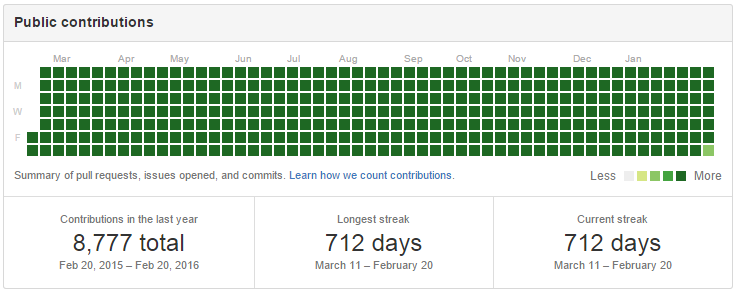

In [166]:
Image(filename='streak.png')